# ML Engineer (Lifesciences) Tech Assessment

# Predicting Kinase Inhibitor Activity with the KinDEL Dataset

## Introduction

... drug discovery, where the goal is to find and develop new therapeutic drugs... At Loka, we help clients speed up this process by optimizing their AI pipelines and applying state-of-the-art models, such as large language models. 

This project specifically focuses on using DNA-encoded libraries, a technology we have explored in collaboration with a biotech client.

---

## Dataset

The KinDEL dataset contains DNA-encoded library (DEL) data for two kinase targets: DDR1 and MAPK14. The data is available on [GitHub](https://github.com/insitro/kindel), along with a set of benchmark models and evaluation scripts. The test set features data from real binding experiments, where binding affinities (Kd values) were measured. The dataset also includes predefined splits using two methods: a random split and a disynthon (building block) split that groups compounds based on shared building blocks. For a more detailed description of the dataset, please refer to the accompanying [paper](https://arxiv.org/pdf/2410.08938).


## Challenge

The objective of this challenge is to build a machine learning model to predict enrichment scores of DEL compounds and evaluate how well it generalizes to real binding affinities (Kd). Some benchmark models are already provided in the GitHub repository, so we encourage candidates to explore novel architectures and methods for representing the molecules.  Feel free to follow the evaluation strategy outlined in the paper, or come up with a new one.

Beyond building a proof of concept, you’re also requested to design a production-ready system architecture. We prefer AWS-native designs but you may use the cloud you know best. This architecture doesn’t need to be implemented, but it should be documented clearly (diagram + rationale) as if it would be handed off to an engineering team.

In [1]:
%load_ext autoreload
import sys
sys.path.append('./kindel')
from kindel.utils.data import get_training_data
from kindel.utils.data import get_testing_data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


Check how data looks like

In [2]:
df_train, df_valid, df_test = get_training_data(target = 'ddr1', split_index=1, split_type = 'random')
df_train

smiles  \
0       CNC(=O)[C@H](CNC(=O)c1ccccc1CNC(=O)c1ccc(-c2no...   
1       CNC(=O)[C@H](CCc1ccccc1)NC(=O)CN1C(=O)[C@@H](N...   
2       CNC(=O)c1sc(C2CCN(C(=O)[C@H](CC3CCCCC3)NCc3csc...   
3       CNC(=O)c1cccc(CNC(=O)[C@H](CC2CCCCC2)NC(=O)c2c...   
4       CNC(=O)[C@@H](CNC(=O)C1CN(C(=O)CCOC)CCO1)NC(=O...   
...                                                   ...   
999994  CNC(=O)[C@H](CCC1CCCCC1)NC(=O)[C@H](CCC(N)=O)N...   
999995  CNC(=O)[C@H](CCNC(=O)[C@H](COCc1ccccc1)NC(=O)c...   
999996  CNC(=O)[C@H](CNC(=O)[C@@H](NC(=O)c1ccc(C)cc1C(...   
999998  CNC(=O)[C@@H]1C[C@H](NC(=O)C(C)C)CN1C(=O)[C@@H...   
999999  CNC(=O)[C@H](CCc1ccccc1)NC(=O)[C@H]1CCN(C(=O)C...   

                                            molecule_hash  \
0       33531ebf0be8ba2787e85a03221df1b41a0512eaf09b1a...   
1       519cddc9ad4ab8538ced2bcfbb17e034240c68b9cd52c4...   
2       d385e4289ecf6fcce902738ee8ea9ab32c43c31107cc9c...   
3       96075c4092ecbba0786c42c576606e70b25d72bcccdc82...   
4       dbb42a3997dd44957450af19bb6a4f4f1ffbdef0beafe4...   
...                                                   ...   
999994  9be0b5f08bc8367089d6403c1baf38939872aa41226b1e...   
999995  0547687f47dc15d9ed8d10df4aa30df20564515b57a616...   
999996  085180dea9802b7a297c4aa646c144d9baeab62d30618c...   
999998  622014205c66a863bc951508335eaf2ddc4f3871f41527...   
999999  957010ed4663186e31fbb759fcd1ac3ab8c074d6683c7d...   

                                      smiles_a  \
0       CNC(=O)[C@H](CN)NC(=O)c1ccc2[nH]ccc2c1   
1                   CNC(=O)[C@@H](N)CCc1ccccc1   
2                    CNC(=O)c1sc(C2CCNCC2)nc1C   
3                          CNC(=O)c1cccc(CN)c1   
4              CNC(=O)[C@@H](CN)NC(=O)c1cccnc1   
...                                        ...   
999994              CNC(=O)[C@@H](N)CCC1CCCCC1   
999995               CNC(=O)[C@H](CCN)N1CCCCC1   
999996        CNC(=O)[C@H](CN)NC(=O)c1ccn(C)n1   
999998    CNC(=O)[C@@H]1C[C@H](NC(=O)C(C)C)CN1   
999999              CNC(=O)[C@@H](N)CCc1ccccc1   

                               smiles_b  \
0       CC1=NC(=NO1)C1=CC=C(C=C1)C(O)=O   
1             OC(=O)CC1=CC(Cl)=C(O)C=C1   
2                      BrC1=NC(C=O)=CS1   
3              CN(C)C1=CC=CC(=C1)C(O)=O   
4                            COCCC(O)=O   
...                                 ...   
999994            CC(C)[C@@H](Br)C(O)=O   
999995   CC1=CC(=CC(=C1)C(F)(F)F)C(O)=O   
999996   CC1=CC(=C(C=C1)C(O)=O)C(F)(F)F   
999998          OC(=O)C1=CC=CC2=C1N=CN2   
999999    CC(NC(=O)OCC1=CC=CC=C1)C(O)=O   

                                                 smiles_c  seq_target_1  \
0             OC(=O)c1ccccc1CNC(=O)OCC1c2ccccc2-c2ccccc12           1.0   
1       OC(=O)CN1c2ccccc2OC[C@H](NC(=O)OCC2c3ccccc3-c3...           5.0   
2       OC(=O)[C@H](CC1CCCCC1)NC(=O)OCC1c2ccccc2-c2ccc...           1.0   
3       OC(=O)[C@H](CC1CCCCC1)NC(=O)OCC1c2ccccc2-c2ccc...           2.0   
4             OC(=O)C1CN(CCO1)C(=O)OCC1c2ccccc2-c2ccccc12           4.0   
...                                                   ...           ...   
999994  NC(=O)CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc12)C(O)=O           0.0   
999995  OC(=O)[C@H](COCc1ccccc1)NC(=O)OCC1c2ccccc2-c2c...           1.0   
999996  OC(=O)[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc12)c1cc...           2.0   
999998                  CC(C)(C)OC(=O)N1CC[C@H](C1)C(O)=O           1.0   
999999                 CC(C)(C)OC(=O)N1CC[C@@H](C1)C(O)=O           0.0   

        seq_target_2  seq_target_3  seq_matrix_1  seq_matrix_2  seq_matrix_3  \
0                6.0           2.0           0.0           4.0           1.0   
1                9.0           7.0           1.0           1.0           1.0   
2                2.0           2.0           0.0           0.0           0.0   
3                2.0           4.0           1.0           3.0           0.0   
4                1.0           2.0           1.0           2.0           0.0   
...              ...           ...           ...           ...           ...   
999994

In [5]:
data = get_testing_data(target = 'ddr1', in_library=True)
print(data['on'].shape)
print(data['off'].shape)
print(data['on'].columns)

(39, 6)
(49, 6)
Index(['smiles', 'molecule_hash', 'y', 'smiles_a', 'smiles_b', 'smiles_c'], dtype='object')


All dataset files contain the following columns:

* smiles - the SMILES representation of the molecule
* molecule_hash - a molecular hash constructed from the synthons that uniquely identifies the molecule
* smiles_a - the SMILES of the synthon A
* smiles_b - the SMILES of the synthon B
* smiles_c - the SMILES of the synthon C



Some compounds in the heldout set do not contain synthon SMILES strings and the molecule hash. It means that these compounds were picked from outside the DEL (external compounds in the extended set).

Besides the molecular structure information, the heldout datasets contain the kd column with the experimental Kd measurements. The DEL compounds in the training dataset files additionally contain the following columns:

* seq_target_1, seq_target_2, seq_target_3 - sequence counts of the molecules bound to the target in triplicate
* seq_matrix_1, seq_matrix_2, seq_matrix_3 - sequence counts of the molecules bound to the control in triplicate
* seq_load - the pre population of the molecule

In [4]:
df_train.columns

Index(['smiles', 'molecule_hash', 'smiles_a', 'smiles_b', 'smiles_c',
       'seq_target_1', 'seq_target_2', 'seq_target_3', 'seq_matrix_1',
       'seq_matrix_2', 'seq_matrix_3', 'seq_load', 'y'],
      dtype='object')

# DDR1 Data exploration and Visualizations

Check Y (Kd) values distributions

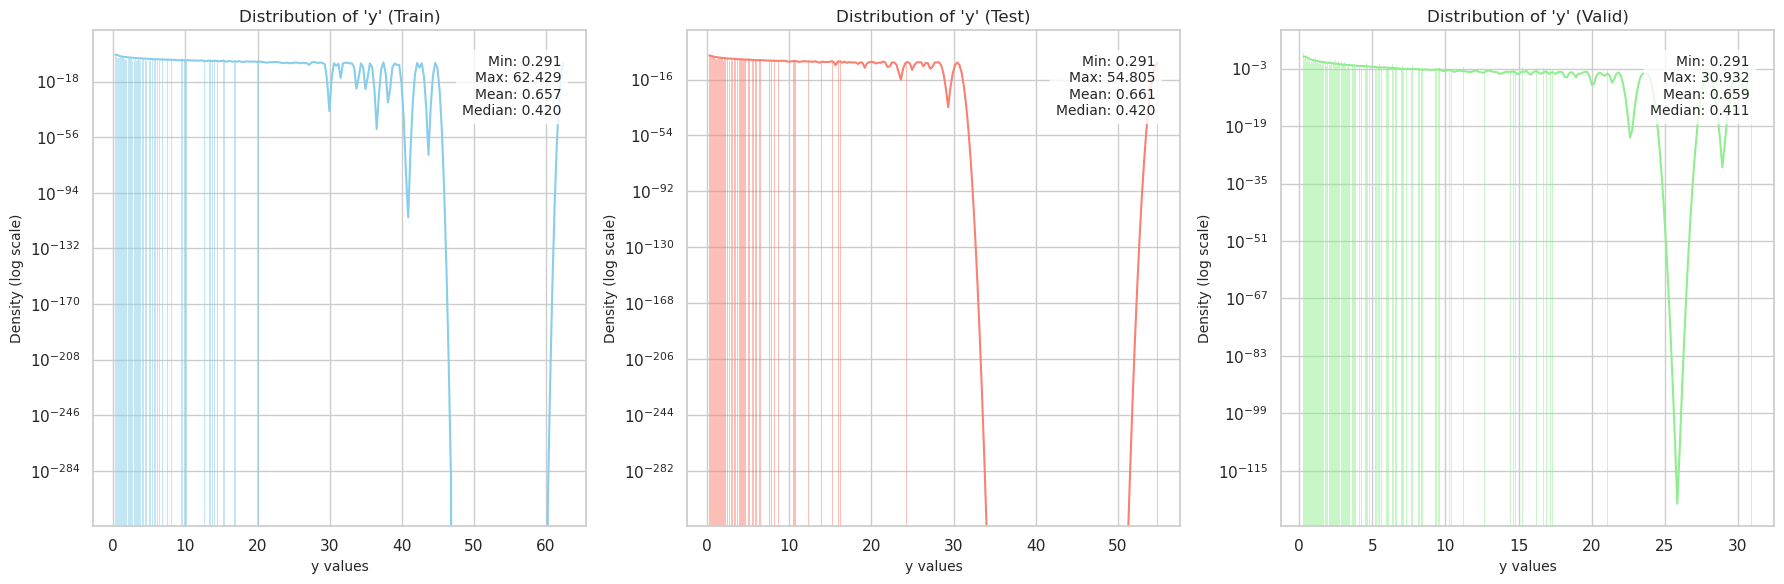

In [7]:
sns.set(style="whitegrid")

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# List of DataFrames and their names
dfs = [(df_train, "Train"), (df_test, "Test"), (df_valid, "Valid")]
colors = ["skyblue", "salmon", "lightgreen"]  # Colors for each plot

# Loop through DataFrames and plot
for i, (df, name) in enumerate(dfs):
    ax = axes[i]
    sns.histplot(df["y"], kde=True, ax=ax, color=colors[i], stat="density")
    ax.set_title(f"Distribution of 'y' ({name})", fontsize=12)
    ax.set_xlabel("y values", fontsize=10)
    ax.set_ylabel("Density (log scale)", fontsize=10)

    # Set log scale on y-axis
    ax.set_yscale("log")

    # Calculate statistics
    y_min = df["y"].min()
    y_max = df["y"].max()
    y_mean = df["y"].mean()
    y_median = df["y"].median()

    # Print statistics inside the plot
    stats_text = (
        f"Min: {y_min:.3f}\n"
        f"Max: {y_max:.3f}\n"
        f"Mean: {y_mean:.3f}\n"
        f"Median: {y_median:.3f}"
    )
    ax.text(
        0.95, 0.95, stats_text,  # x, y position (relative to axes)
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.8)
    )

plt.tight_layout()  # Adjust spacing
plt.show()

/tmp/ipykernel_1434536/3784344888.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="Dataset", y="y", palette=["skyblue", "salmon", "lightgreen"])


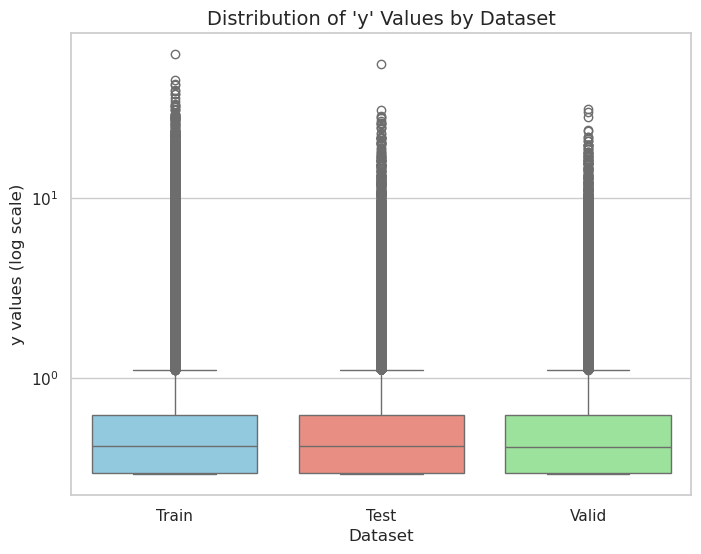

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x="Dataset", y="y", palette=["skyblue", "salmon", "lightgreen"])
plt.yscale("log")  # log-scale
plt.title("Distribution of 'y' Values by Dataset", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("y values (log scale)", fontsize=12)
plt.show()

Check the compounds. The 10 with highest binding affinity, the 10 with lower and the 10 with higher Kd but from the top whisker ( excluding outliers) 

Top 10 compounds with highest binding:


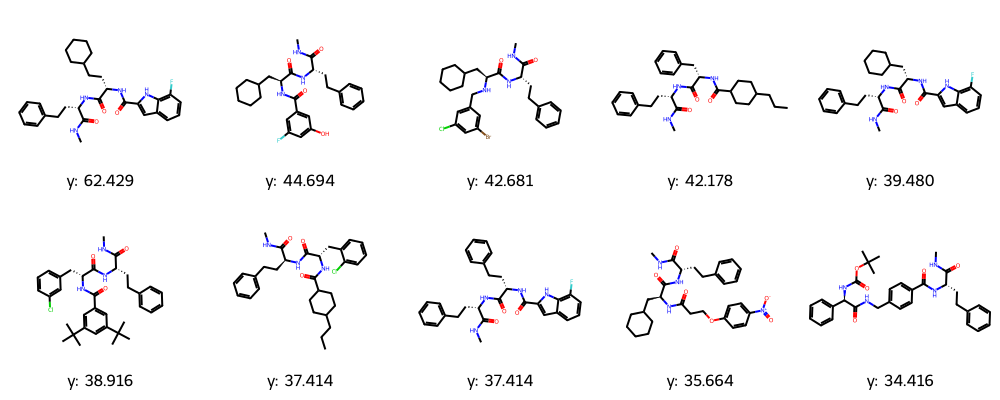


Top 10 compounds with lowest binding:


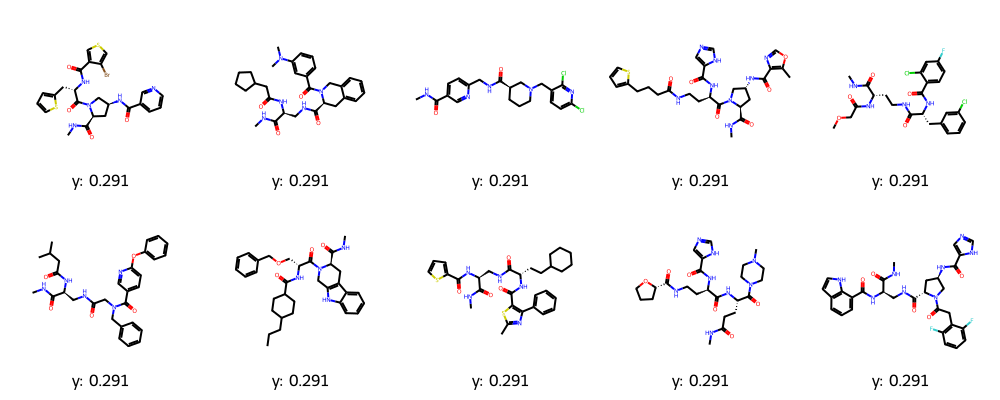


Top 10 non-outlier compounds:


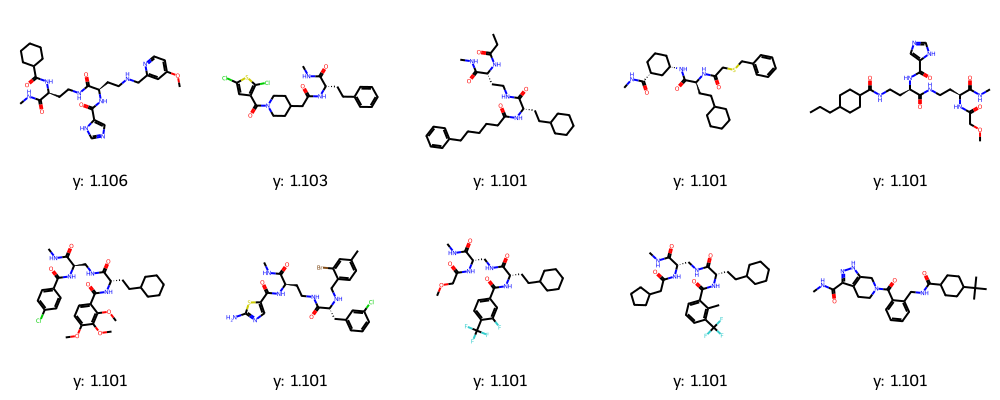

In [12]:
from rdkit.Chem import Draw
from IPython.display import display

def draw_grid_compounds(df, title="Compounds"):
    # Create a list of molecules and legends (y values)
    molecules = []
    legends = []
    for idx, row in df.iterrows():
        mol = Chem.MolFromSmiles(row["smiles"])
        if mol is not None:
            molecules.append(mol)
            legends.append(f"y: {row['y']:.3f}")  # Format y value to 3 decimal places
        else:
            print(f"Invalid SMILES: {row['smiles']}")

    # Generate the grid image (5 columns, 2 rows)
    if molecules:
        img = Draw.MolsToGridImage(
            mols=molecules,
            molsPerRow=5,  # 5 columns
            subImgSize=(200, 200),  # Size of each molecule image
            legends=legends,  # Add y values below each molecule
            maxMols=10,  # Only show top 10 (2 rows × 5 columns)
        )
        display(img)  # Display the grid in Jupyter
    else:
        print("No valid molecules to display.")

# Top 10 highest-binding compounds
top_10_high = df_train.nlargest(10, "y")[["smiles", "y"]]
print("Top 10 compounds with highest binding:")
draw_grid_compounds(top_10_high, "Top 10 Highest Binding")

# Top 10 lowest-binding compounds
top_10_low = df_train.nsmallest(10, "y")[["smiles", "y"]]
print("\nTop 10 compounds with lowest binding:")
draw_grid_compounds(top_10_low, "Top 10 Lowest Binding")

# Top 10 non-outlier compounds
Q1 = df_train["y"].quantile(0.25)
Q3 = df_train["y"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
non_outliers = df_train[(df_train["y"] >= lower_bound) & (df_train["y"] <= upper_bound)]
top_10_non_outliers = non_outliers.nlargest(10, "y")[["smiles", "y"]]
print("\nTop 10 non-outlier compounds:")
draw_grid_compounds(top_10_non_outliers, "Top 10 Non-Outliers")


## Compound representation

Kindel paper uses only Morgan fingerprints. 
Here I explore different methods of representing compounds and it's relation (or not) with Y values. 

    * Morgan fingerprints ( 2048 
    * ***MACCS keys***
    


I will use ony the first split of the random splits. 

In [2]:
target = 'ddr1'
split_index = 1
split_type = 'random'
df_train, df_valid, df_test = get_training_data(target, split_index=split_index, split_type=split_type)

***Morgan Fingerprits circular - from Kindel***

In [16]:
from featurizer import MorganFeaturizer
X_train, y_train = MorganFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)
print(X_train[0][:30]) # binary 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [14:42<00:00, 906.75it/s]


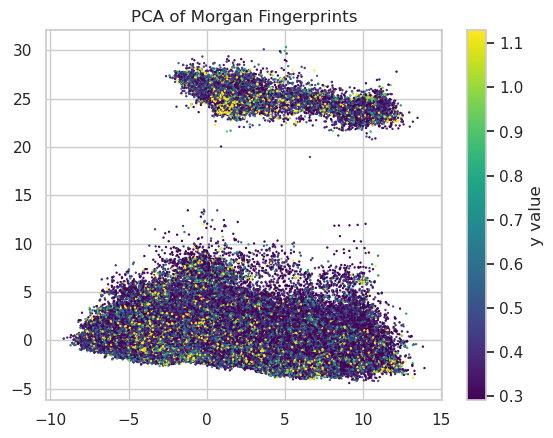

In [19]:
# PCA of Morgan fingerprints
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))
Q3 = df_train["y"].quantile(0.90)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["y"], 
            cmap="viridis", s=0.5,
            vmax=Q3,# Cap at 90 perccentile
           )
plt.colorbar(label="y value")
plt.title("PCA of Morgan Fingerprints")
plt.show()

# # Re-fit PCA with 3 components
# pca_3d = PCA(n_components=3)
# X_pca_3d = pca_3d.fit_transform(StandardScaler().fit_transform(X_train))

# # Plot 3D PCA
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")
# scatter = ax.scatter(
#     X_pca_3d[:, 0],
#     X_pca_3d[:, 1],
#     X_pca_3d[:, 2],
#     c=df_train["y"],
#     cmap="viridis",
#     vmax=Q3,
#     alpha=0.6,
#     s=10,
# )
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# plt.title("3D PCA of Morgan Fingerprints")
# plt.colorbar(scatter, label="y value (capped at Q3)")
# plt.show()

The PCA shows some separation based on the Morgan fingerprints, but this does not seem to be related to the target Y. I could look at the PCA loadings, but since Morgan fingerprints are not easy to interpret, this would likely not give much useful insight. I will check the molecules that have extreme values for PC1 and PC2. 

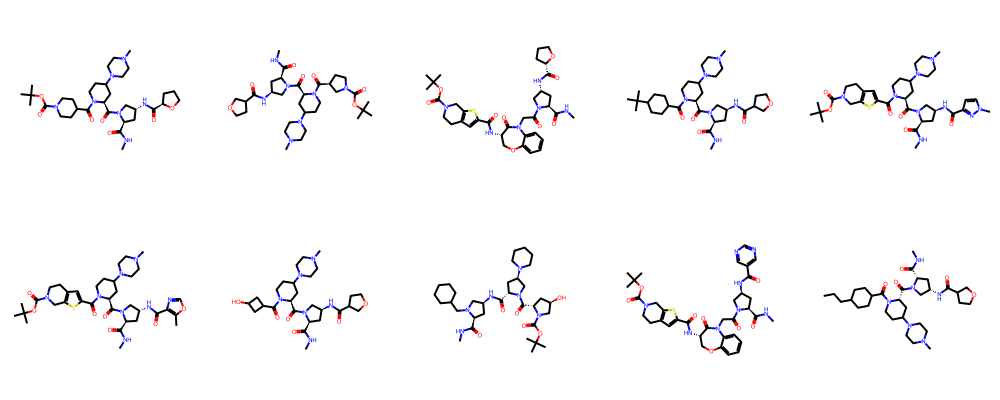

In [20]:
# Get loadings for PC1 and PC2
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to get features x components
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
)

# Sort features by their contribution to PC1 and PC2
pc1_loadings = loadings["PC1"].abs().sort_values(ascending=False)
pc2_loadings = loadings["PC2"].abs().sort_values(ascending=False)

# # Top 10 features for PC1 and PC2
# print("Top features for PC1:")
# print(pc1_loadings.head(10))

# print("\nTop features for PC2:")
# print(pc2_loadings.head(10))

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# pc1_loadings.head(10).plot(kind="barh", title="Top Features for PC1")
# plt.subplot(1, 2, 2)
# pc2_loadings.head(10).plot(kind="barh", title="Top Features for PC2")
# plt.tight_layout()
# plt.show()

pc1_extreme_indices = X_pca[:, 0].argsort()[::-1][:10]  # Top 10 for PC1
pc1_extreme_molecules = df_train.iloc[pc1_extreme_indices]
# Visualize top molecules for PC1
mols = [Chem.MolFromSmiles(smiles) for smiles in pc1_extreme_molecules["smiles"]]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
img

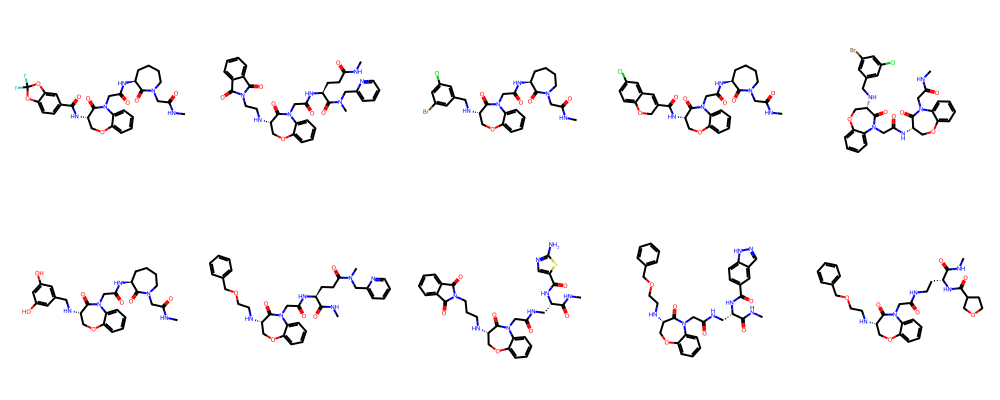

In [21]:
pc2_extreme_indices = X_pca[:, 1].argsort()[::-1][:10]  # Top 10 for PC1
pc2_extreme_molecules = df_train.iloc[pc2_extreme_indices]
# Visualize top molecules for PC1
mols = [Chem.MolFromSmiles(smiles) for smiles in pc2_extreme_molecules["smiles"]]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
img

***MACCS keys***

In [4]:
from featurizer import MACCSFeaturizer
X_train, y_train = MACCSFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [17:12<00:00, 775.00it/s]


(800000, 167)


In [7]:
# Column names for MACCS keys (167 bits)
maccs_feature_names = [f"MACCS_{i}" for i in range(167)]
maccs_features_df = pd.DataFrame(X_train, columns=maccs_feature_names)
maccs_features_df["y"] = y_train  # Add the 'y' values as a column
# print(X_train[0][:500]) # binary

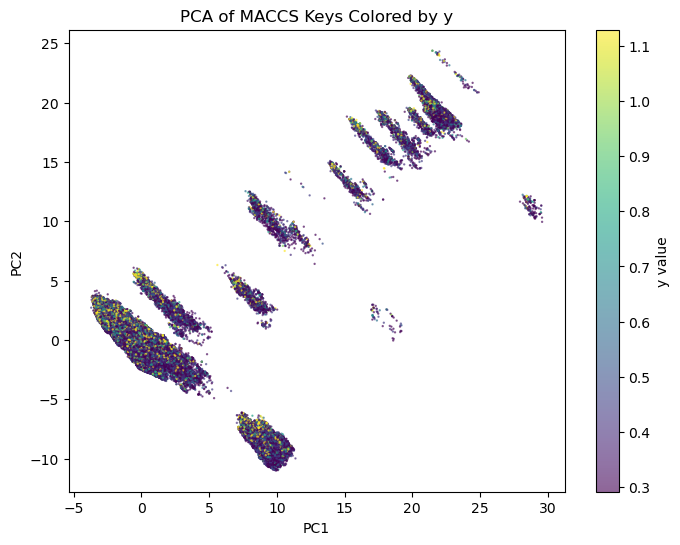

In [9]:
# Standardize the MACCS features
scaler = StandardScaler()
maccs_scaled = scaler.fit_transform(maccs_features_df.drop(columns=["y"]))
pca = PCA(n_components=2)  # You can also try n_components=3 for 3D
maccs_pca = pca.fit_transform(maccs_scaled)
Q3 = maccs_features_df["y"].quantile(0.90)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(maccs_pca[:, 0], maccs_pca[:, 1], 
                      c=maccs_features_df["y"], 
                      cmap="viridis", alpha=0.6, s= 0.5,
                     vmax=Q3,
                     )
plt.colorbar(scatter, label="y value")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MACCS Keys Colored by y")
plt.show()

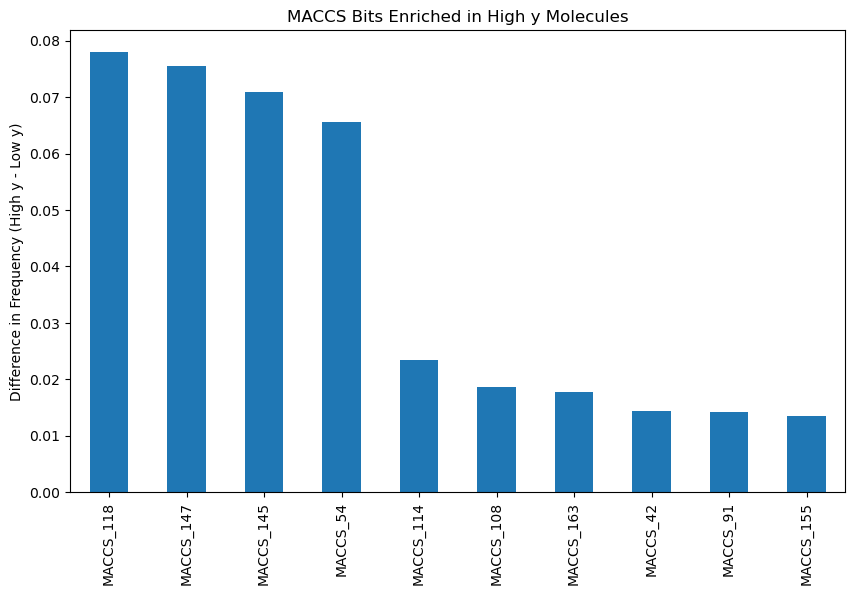

In [10]:
# Split molecules into high and low y
median_y = maccs_features_df["y"].median()
high_y = maccs_features_df[maccs_features_df["y"] > median_y]
low_y = maccs_features_df[maccs_features_df["y"] <= median_y]

# Calculate the frequency of each bit in high vs. low y
high_y_freq = high_y.drop(columns=["y"]).mean()
low_y_freq = low_y.drop(columns=["y"]).mean()

# Calculate the difference in frequency
freq_diff = high_y_freq - low_y_freq
freq_diff.sort_values(ascending=False, inplace=True)

# Plot the top 10 bits enriched in high y
plt.figure(figsize=(10, 6))
freq_diff.head(10).plot(kind="bar")
plt.title("MACCS Bits Enriched in High y Molecules")
plt.ylabel("Difference in Frequency (High y - Low y)")
plt.show()

***Physicohemical features*** - Implemented (from RDKit)

* MolWt - Molecular weight
* MolLogP -  LogP (lipophilicity)
* NumHDonors - Number of hydrogen bond donors
* NumHAcceptors - Number of hydrogen bond acceptors
* TPSA - Topological polar surface area
            

In [11]:
from featurizer import PhysChemFeaturizer
X_train, y_train = PhysChemFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [08:30<00:00, 1566.43it/s]

(800000, 5)


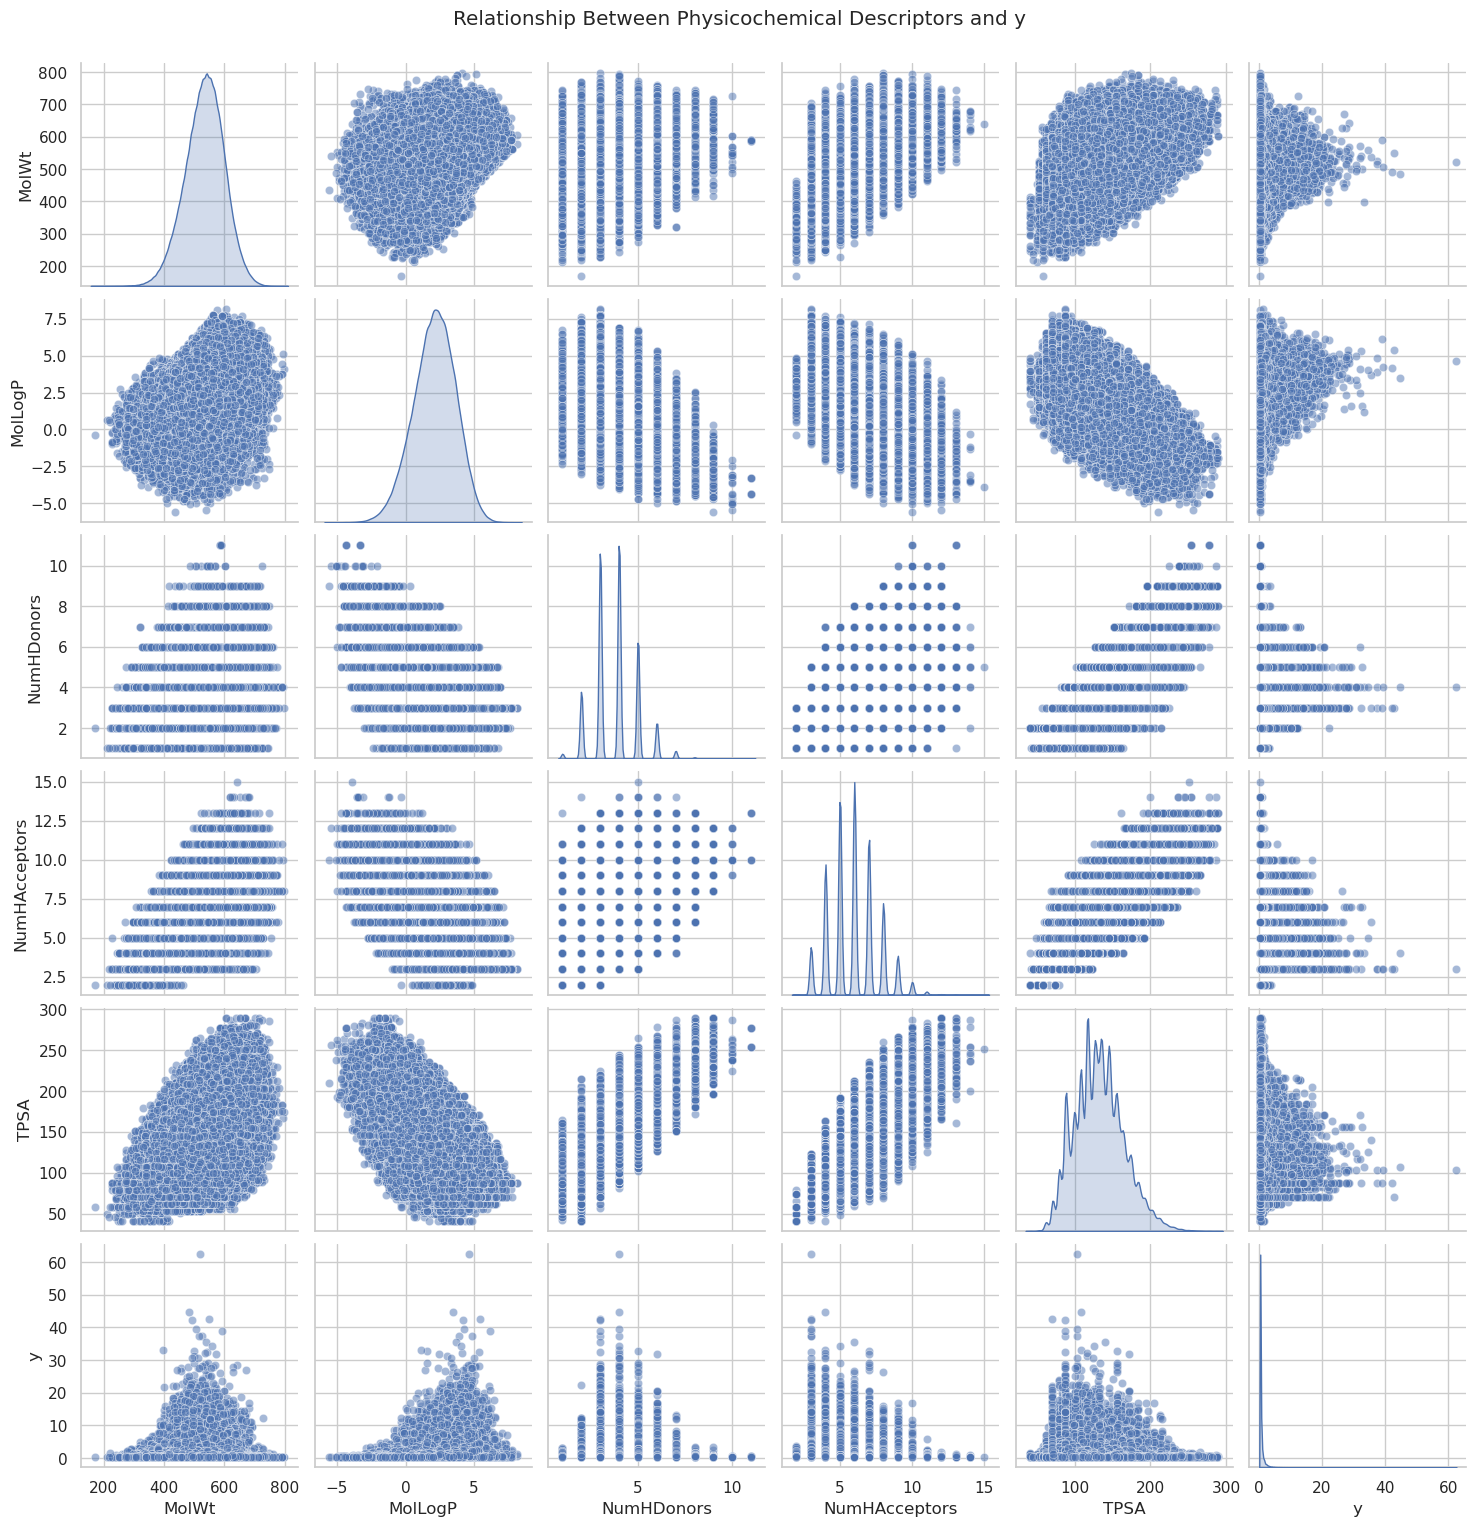

In [23]:
X_train_df = pd.DataFrame(X_train, columns=["MolWt","MolLogP","NumHDonors","NumHAcceptors","TPSA"])
X_train_df['y'] = y_train

sns.pairplot(X_train_df, diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Relationship Between Physicochemical Descriptors and y", y=1.02)
plt.show()

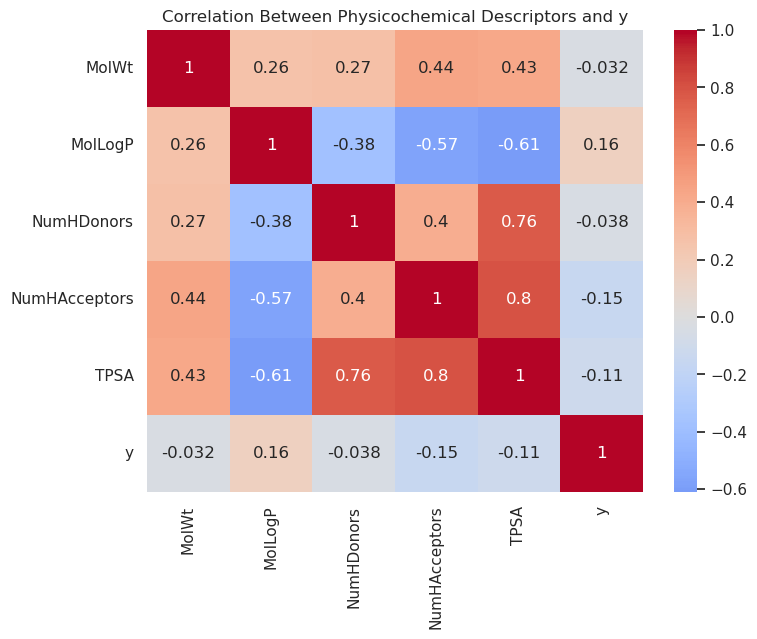

In [44]:
# Calculate correlations
corr_matrix = X_train_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Physicochemical Descriptors and y")
plt.show()

***Substructure Count - Implemented***

In [13]:
from featurizer import SubstructureCountFeaturizer
substructure_featurizer = SubstructureCountFeaturizer()
X_train, y_train = substructure_featurizer.featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [04:38<00:00, 2873.01it/s]

(800000, 8)


In [14]:
# Column names for substructure counts
substructure_feature_names = list(substructure_featurizer.substructures.keys())

# Create a DataFrame
substructure_features_df = pd.DataFrame(
    X_train, columns=substructure_feature_names
)
substructure_features_df["y"] = y_train  # Add the 'y' values as a column
# Summary statistics for each substructure
print(substructure_features_df.describe())

       aromatic_rings       halogens       hydroxyl         amines  \
count   800000.000000  800000.000000  800000.000000  800000.000000   
mean        11.582083       0.658930       0.128664       3.310265   
std          5.382017       1.013918       0.365721       0.850423   
min          0.000000       0.000000       0.000000       1.000000   
25%          6.000000       0.000000       0.000000       3.000000   
50%         12.000000       0.000000       0.000000       3.000000   
75%         16.000000       1.000000       0.000000       4.000000   
max         32.000000       9.000000       5.000000       8.000000   

       carboxylic_acid        ketones         esters         amides  \
count    800000.000000  800000.000000  800000.000000  800000.000000   
mean          0.019543       2.642628       0.067505       3.682390   
std           0.138422       0.826130       0.250895       0.807191   
min           0.000000       0.000000       0.000000       1.000000   
25%           

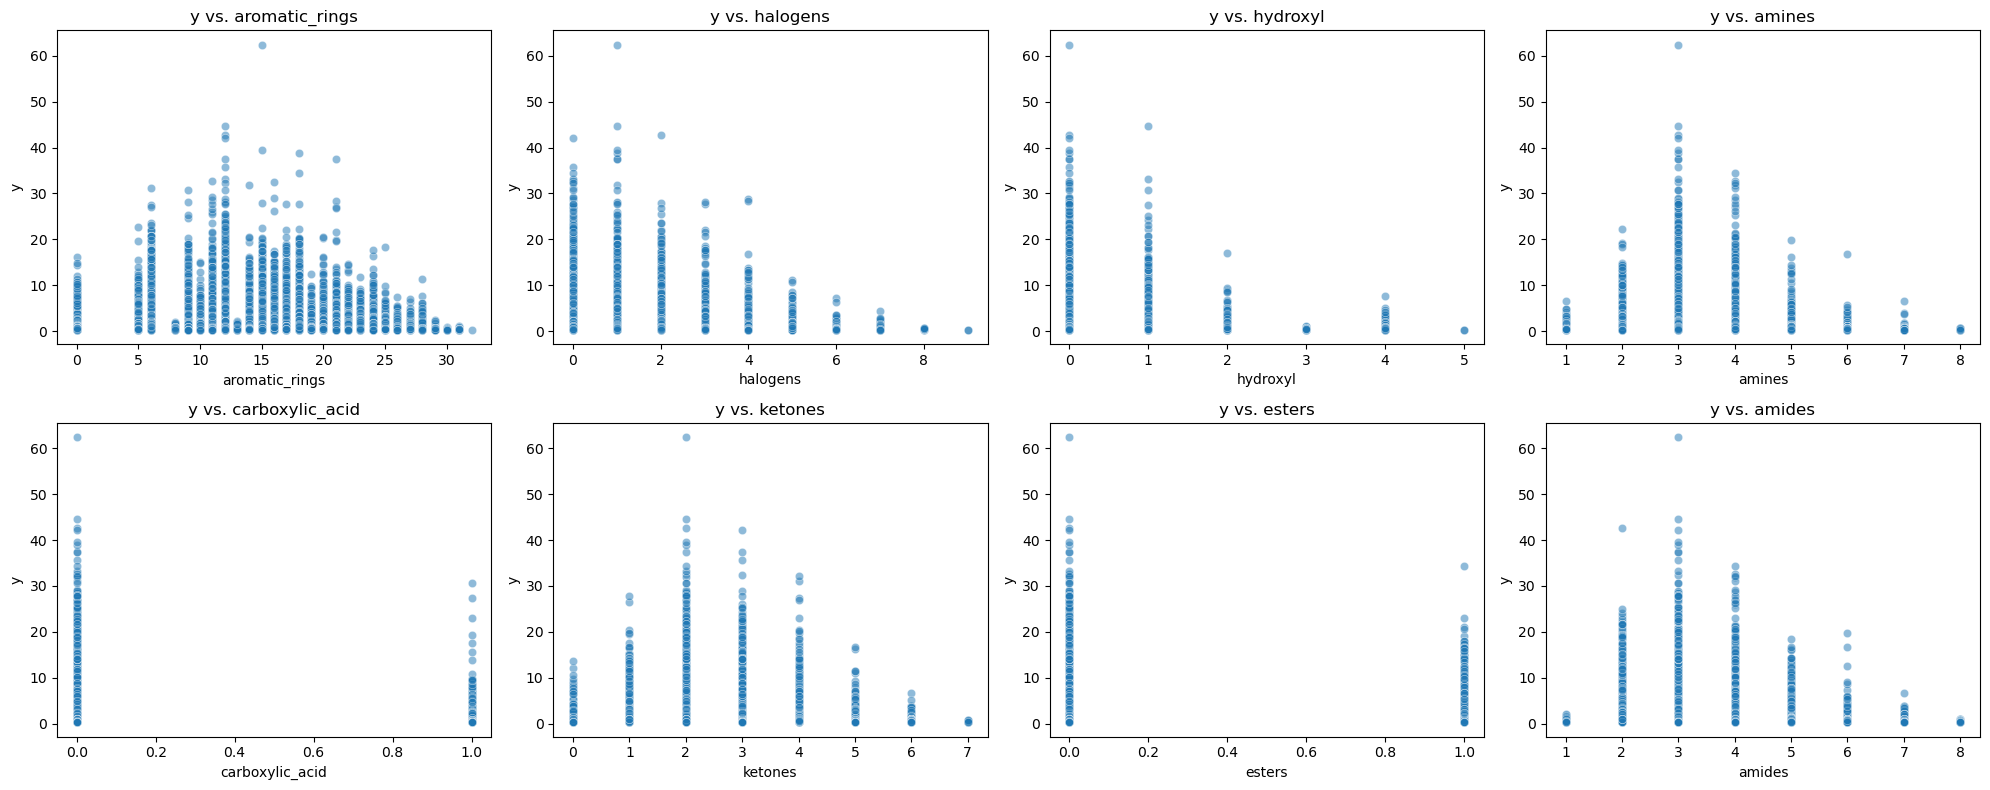

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten for easy indexing

# Plot each feature
for i, substructure in enumerate(substructure_feature_names):
    sns.scatterplot(
        data=substructure_features_df,
        x=substructure,
        y="y",
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f"y vs. {substructure}")

plt.tight_layout()
plt.show()

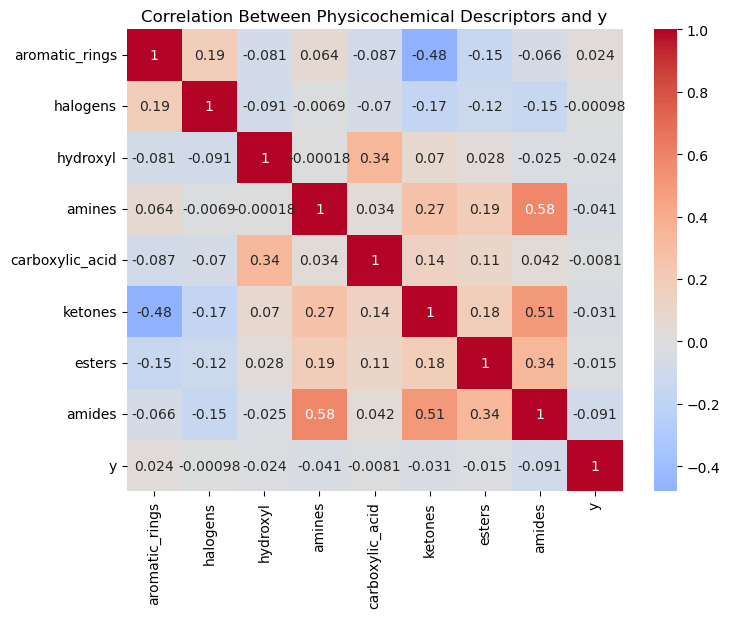

In [20]:
# Calculate correlations
corr_matrix = substructure_features_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Physicochemical Descriptors and y")
plt.show()

***ChemBERTa embeddings*** 

In [21]:
from featurizer import ChemBERTaFeaturizer
chemberta_featurizer = ChemBERTaFeaturizer()
chemberta_features, y = chemberta_featurizer.featurize_df(df_train, smiles_col="smiles", label_col="y")
print("ChemBERTa features shape:", chemberta_features.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [47:39<00:00, 279.74it/s]


ChemBERTa features shape: (800000, 384)


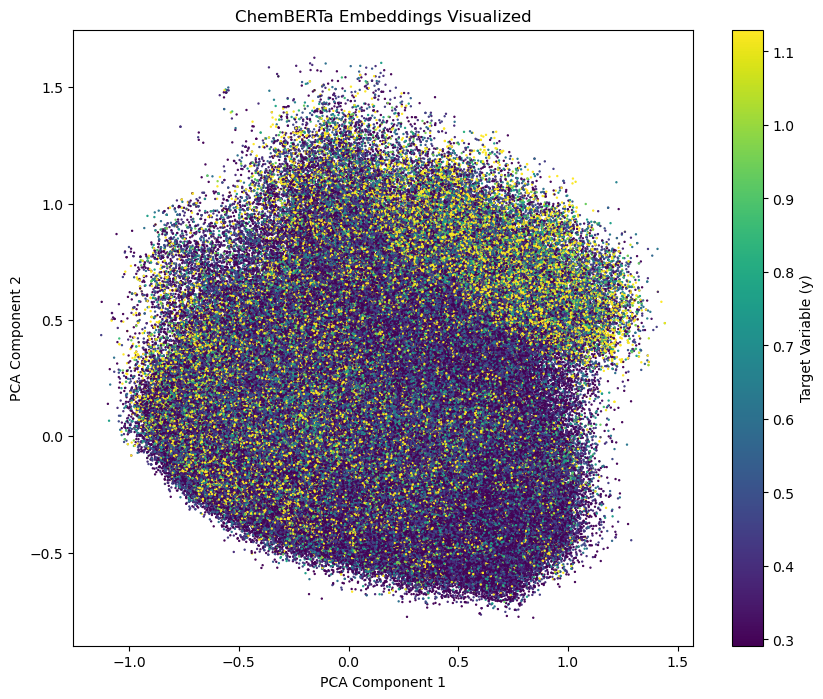

In [22]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(chemberta_features)
P90= np.percentile(df_train['y'], 90)
# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df_train['y'],
            cmap='viridis', vmax = P90, s=0.5)
plt.colorbar(label='Target Variable (y)')
plt.title('ChemBERTa Embeddings Visualized')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# MAPK14 Data exploration and Visualizations

In [3]:
df_train, df_valid, df_test = get_training_data(target = 'mapk14', split_index=1, split_type = 'random')
df_train

smiles  \
1       CNC(=O)[C@@H](CCNC(=O)[C@@H](CCNC(=O)c1ccc2ccc...   
2       CNC(=O)[C@H](CNC(=O)[C@@H](CNC(=O)COc1ccc(C)cc...   
3       CNC(=O)[C@H](CNC(=O)[C@@H](COCc1ccccc1)NC(=O)C...   
4       CNC(=O)[C@@H](CCNC(=O)[C@@H]1C[C@@H](NC(=O)c2c...   
5       CNC(=O)[C@H](CNC(=O)CC1CN(C(=O)C2CCN(C(=O)OC(C...   
...                                                   ...   
999993  CNC(=O)[C@H](CNC(=O)CN1CCC(NC(=O)c2cc(F)cc(Cl)...   
999994  CNC(=O)[C@@H]1C[C@H](NC(=O)[C@H]2Cc3ccccc3CN2C...   
999996  CNC(=O)[C@@H]1C[C@@H](NC(=O)c2coc(C)n2)CN1C(=O...   
999997  CNC(=O)[C@@H](CNC(=O)[C@H](CNC(=O)c1cccnc1SC)N...   
999999  CNC(=O)[C@@H]1C[C@H](NC(=O)[C@H]2CCCO2)CN1C(=O...   

                                            molecule_hash  \
1       ae7e392cb3844707da33ee6a00e4934037adda05340bfd...   
2       f3305b1c9280c53c77cd24bc919b3dc73171e628e0491b...   
3       08acb55545eb03f7c719875537d5b31fb4e1507810bff1...   
4       43bf37d24d86c3ac691b5159ff22dec7dcfbb680b0501d...   
5       5a64314016fa3c10f446b7aae75ff6bfd790b0c3c51bab...   
...                                                   ...   
999993  a61294c6c629bd53dbdb786b4dc26867b0b2377d07a98c...   
999994  bd53bf6308124ae4feb7677094bf53c3c1ac397ffc7c14...   
999996  ae69cbd6754aacd26244396d9cb32cbc294d84f944c429...   
999997  c59f1b53d15c51393157a8820d16b7bd283a177201d4f0...   
999999  5801f940467363244df99ac166254e36d94d45e1a5aa4d...   

                                          smiles_a  \
1                    CNC(=O)[C@@H](CCN)NC(=O)C(C)C   
2                 CNC(=O)[C@H](CN)NC(=O)c1ccn(C)n1   
3                 CNC(=O)[C@H](CN)NC(=O)c1ccn(C)n1   
4               CNC(=O)[C@@H](CCN)NC(=O)c1cn[nH]c1   
5           CNC(=O)[C@H](CN)NC(=O)c1cccc2[nH]ccc12   
...                                            ...   
999993              CNC(=O)[C@H](CN)NC(=O)c1ccncc1   
999994         CNC(=O)[C@@H]1C[C@H](N)CN1Cc1ccccn1   
999996  CNC(=O)[C@@H]1C[C@@H](NC(=O)c2coc(C)n2)CN1   
999997     CNC(=O)[C@@H](CN)NC(=O)c1cccc2[nH]ccc12   
999999  CNC(=O)[C@@H]1C[C@H](NC(=O)[C@H]2CCCO2)CN1   

                                  smiles_b  \
1                OC(=O)C1=CC=C2C=CC=CC2=N1   
2                   CC1=CC=C(OCC(O)=O)C=C1   
3                             OC(=O)C1CCC1   
4               COC1=CC(OC)=C(CC(O)=O)C=C1   
5           CC(C)(C)OC(=O)N1CCC(CC1)C(O)=O   
...                                    ...   
999993            OC(=O)C1=CC(F)=CC(Cl)=C1   
999994           COC1=CC=CC(CCC(O)=O)=C1OC   
999996  OC(=O)C1=C(C=CC(O)=C1)[N+]([O-])=O   
999997               CSC1=C(C=CC=N1)C(O)=O   
999999              OC(=O)[C@@H]1CCC(=O)N1   

                                                 smiles_c  seq_target_1  \
1       CC(C)(C)OC(=O)NCC[C@@H](NC(=O)OCC1c2ccccc2-c2c...           8.0   
2       CC(C)(C)OC(=O)NC[C@@H](NC(=O)OCC1c2ccccc2-c2cc...           4.0   
3       OC(=O)[C@@H](COCc1ccccc1)NC(=O)OCC1c2ccccc2-c2...           4.0   
4       CC(C)(C)OC(=O)N1C[C@@H](C[C@H]1C(O)=O)NC(=O)OC...           7.0   
5            OC(=O)CC1CN(CCO1)C(=O)OCC1c2ccccc2-c2ccccc12           6.0   
...                                                   ...           ...   
999993      OC(=O)CN1CCC(CC1)NC(=O)OCC1c2ccccc2-c2ccccc12           4.0   
999994  OC(=O)[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2cc...           4.0   
999996  OC(=O)[C@@H](Cc1cccc(Cl)c1)NC(=O)OCC1c2ccccc2-...           3.0   
999997  CC(C)(C)OC(=O)NC[C@H](NC(=O)OCC1c2ccccc2-c2ccc...           5.0   
999999  [H][C@@](CCC(O)=O)(NC(=O)OC(C)(C)C)C(=O)OC, CN...           5.0   

        seq_target_2  seq_target_3  seq_matrix_1  seq_matrix_2  seq_matrix_3  \
1                1.0           1.0           3.0           0.0           3.0   
2                1.0           0.0           0.0           0.0           0.0   
3                1.0           0.0           0.0           0.0           0.0   
4                0.0           1.0           1.0           3.0           0.0   
5                1.0           0.0           0.0           1.0           0.0   
..

Check Y (Kd) values distributions

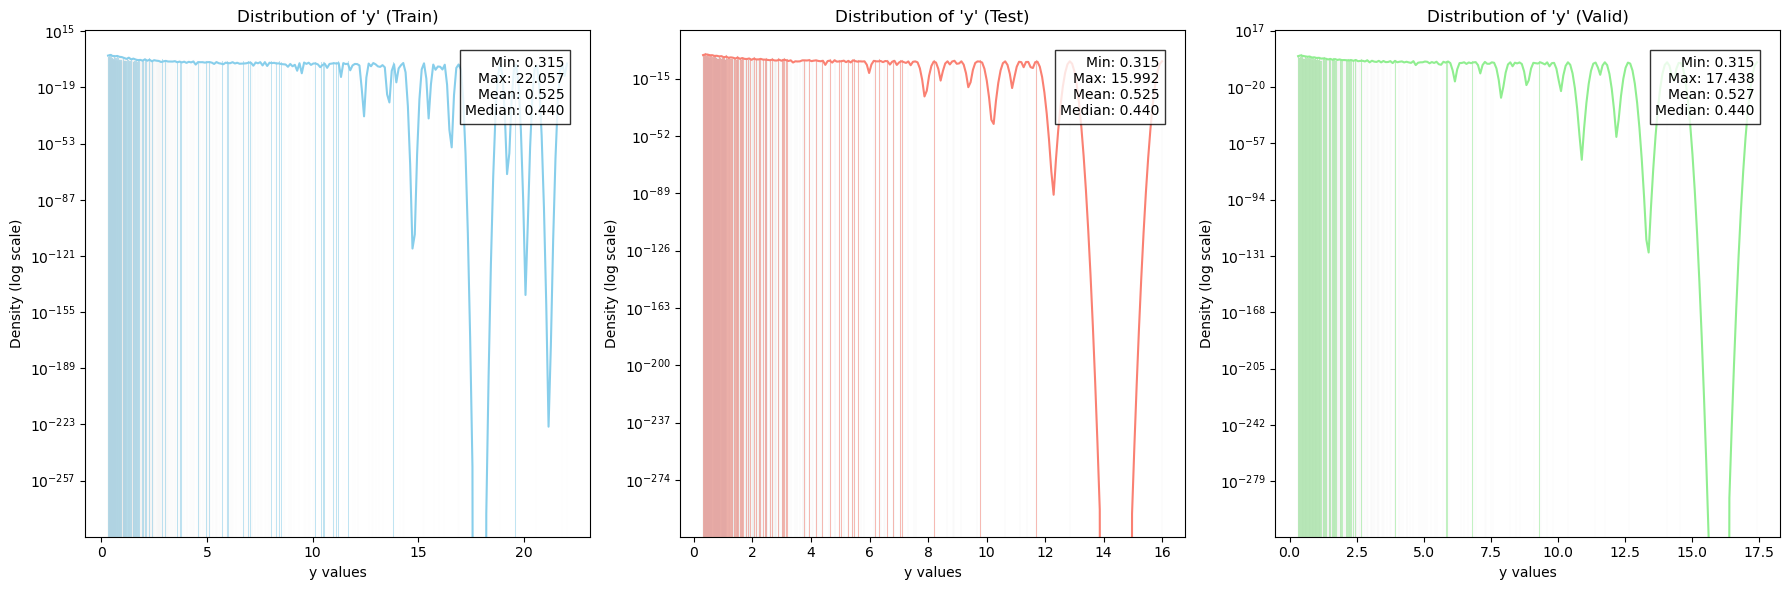

/tmp/ipykernel_2370872/1090578207.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="Dataset", y="y", palette=["skyblue", "salmon", "lightgreen"])


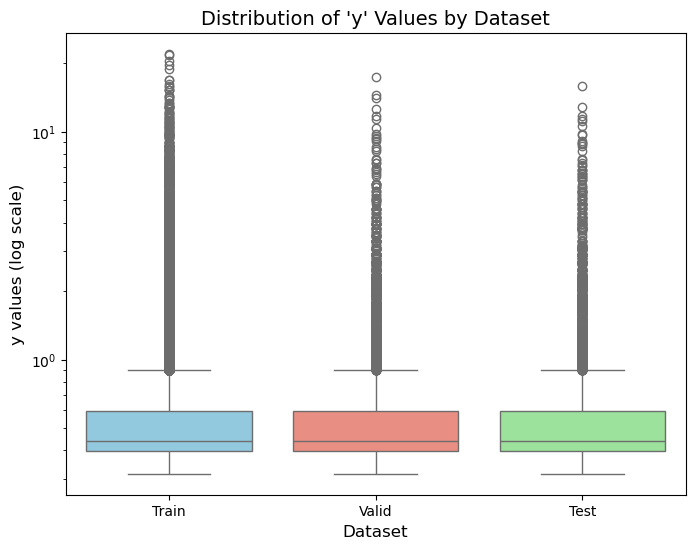

In [28]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# List of DataFrames and their names
dfs = [(df_train, "Train"), (df_test, "Test"), (df_valid, "Valid")]
colors = ["skyblue", "salmon", "lightgreen"]  # Colors for each plot

# Loop through DataFrames and plot
for i, (df, name) in enumerate(dfs):
    ax = axes[i]
    sns.histplot(df["y"], kde=True, ax=ax, color=colors[i], stat="density")
    ax.set_title(f"Distribution of 'y' ({name})", fontsize=12)
    ax.set_xlabel("y values", fontsize=10)
    ax.set_ylabel("Density (log scale)", fontsize=10)

    # Set log scale on y-axis
    ax.set_yscale("log")

    # Calculate statistics
    y_min = df["y"].min()
    y_max = df["y"].max()
    y_mean = df["y"].mean()
    y_median = df["y"].median()

    # Print statistics inside the plot
    stats_text = (
        f"Min: {y_min:.3f}\n"
        f"Max: {y_max:.3f}\n"
        f"Mean: {y_mean:.3f}\n"
        f"Median: {y_median:.3f}"
    )
    ax.text(
        0.95, 0.95, stats_text,  # x, y position (relative to axes)
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.8)
    )

plt.tight_layout()  # Adjust spacing
plt.show()

splits = {
    "Train": df_train,
    "Valid": df_valid,
    "Test": df_test
}

combined_df = pd.concat(
    [df.assign(Dataset=name) for name, df in splits.items()],
    ignore_index=True
)
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x="Dataset", y="y", palette=["skyblue", "salmon", "lightgreen"])
plt.yscale("log")  # log-scale
plt.title("Distribution of 'y' Values by Dataset", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("y values (log scale)", fontsize=12)
plt.show()

Check the compounds. The 10 with highest binding affinity, the 10 with lower and the 10 with higher Kd but from the top whisker ( excluding outliers) 

Top 10 compounds with highest binding:


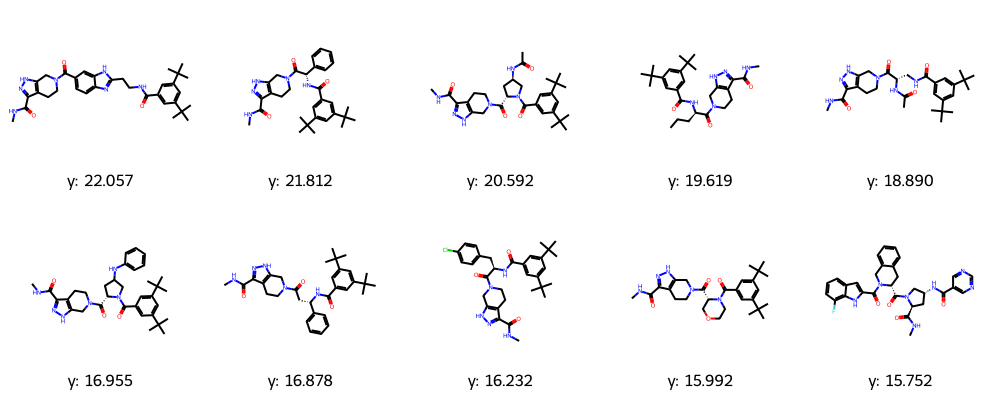


Top 10 compounds with lowest binding:


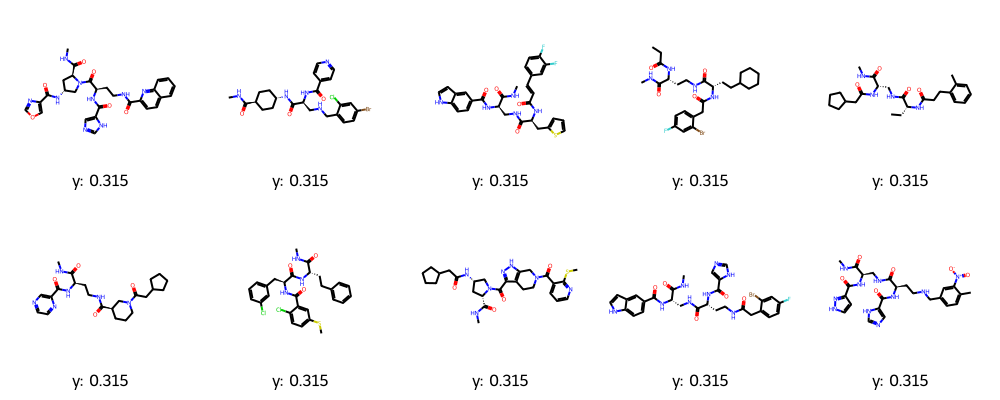


Top 10 non-outlier compounds:


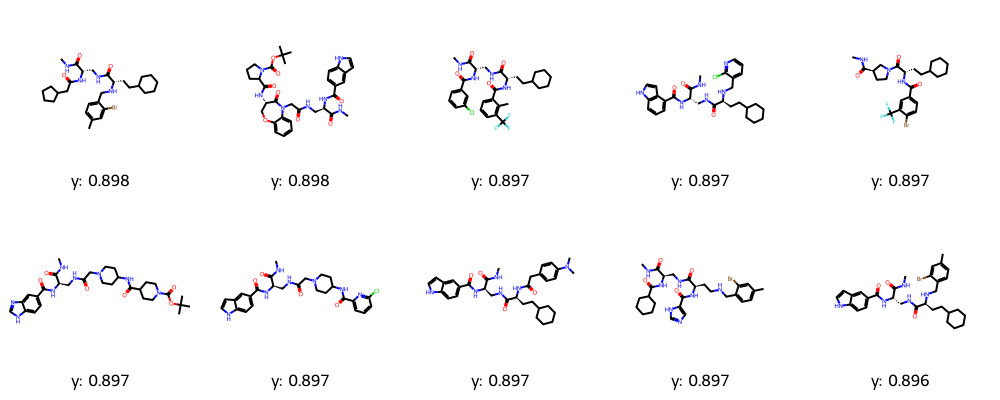

In [31]:
# Top 10 highest-binding compounds
top_10_high = df_train.nlargest(10, "y")[["smiles", "y"]]
print("Top 10 compounds with highest binding:")
draw_grid_compounds(top_10_high, "Top 10 Highest Binding")

# Top 10 lowest-binding compounds
top_10_low = df_train.nsmallest(10, "y")[["smiles", "y"]]
print("\nTop 10 compounds with lowest binding:")
draw_grid_compounds(top_10_low, "Top 10 Lowest Binding")

# Top 10 non-outlier compounds
Q1 = df_train["y"].quantile(0.25)
Q3 = df_train["y"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
non_outliers = df_train[(df_train["y"] >= lower_bound) & (df_train["y"] <= upper_bound)]
top_10_non_outliers = non_outliers.nlargest(10, "y")[["smiles", "y"]]
print("\nTop 10 non-outlier compounds:")
draw_grid_compounds(top_10_non_outliers, "Top 10 Non-Outliers")

***Morgan Fingerprits circular - from Kindel***

In [33]:
from featurizer import MorganFeaturizer
X_train, y_train = MorganFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)
print(X_train[0][:30]) # binary 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [15:27<00:00, 862.14it/s]


(800000, 2048)
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


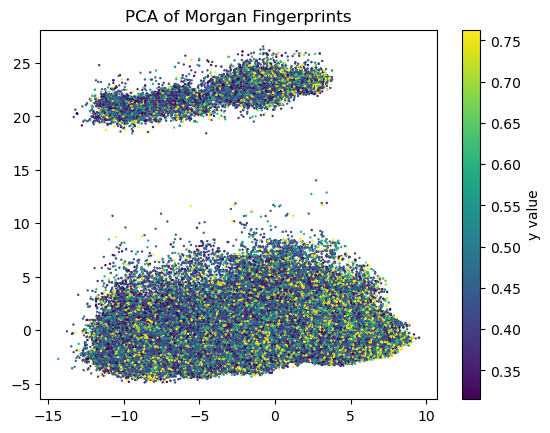

In [34]:
# PCA of Morgan fingerprints
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))
Q3 = df_train["y"].quantile(0.90)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["y"], 
            cmap="viridis", s=0.5,
            vmax=Q3,# Cap at 90 perccentile
           )
plt.colorbar(label="y value")
plt.title("PCA of Morgan Fingerprints")
plt.show()

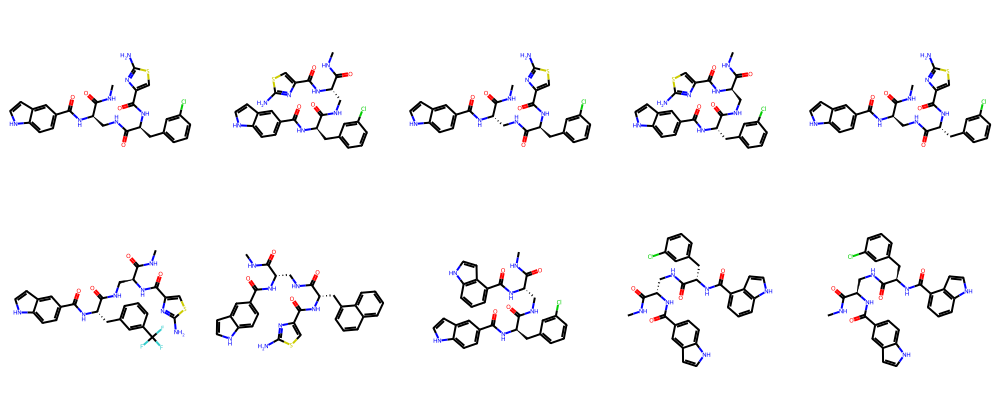

In [35]:
# Get loadings for PC1 and PC2
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to get features x components
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
)

# Sort features by their contribution to PC1 and PC2
pc1_loadings = loadings["PC1"].abs().sort_values(ascending=False)
pc2_loadings = loadings["PC2"].abs().sort_values(ascending=False)

pc1_extreme_indices = X_pca[:, 0].argsort()[::-1][:10]  # Top 10 for PC1
pc1_extreme_molecules = df_train.iloc[pc1_extreme_indices]
# Visualize top molecules for PC1
mols = [Chem.MolFromSmiles(smiles) for smiles in pc1_extreme_molecules["smiles"]]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
img

pc2_extreme_indices = X_pca[:, 1].argsort()[::-1][:10]  # Top 10 for PC1
pc2_extreme_molecules = df_train.iloc[pc2_extreme_indices]
# Visualize top molecules for PC1
mols = [Chem.MolFromSmiles(smiles) for smiles in pc2_extreme_molecules["smiles"]]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
img

***MACCS keys***

In [44]:
from featurizer import MACCSFeaturizer
X_train, y_train = MACCSFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [17:42<00:00, 752.95it/s]

(800000, 167)


In [45]:
# Column names for MACCS keys (167 bits)
maccs_feature_names = [f"MACCS_{i}" for i in range(167)]
maccs_features_df = pd.DataFrame(X_train, columns=maccs_feature_names)
maccs_features_df["y"] = y_train  # Add the 'y' values as a column
# print(X_train[0][:500]) # binary

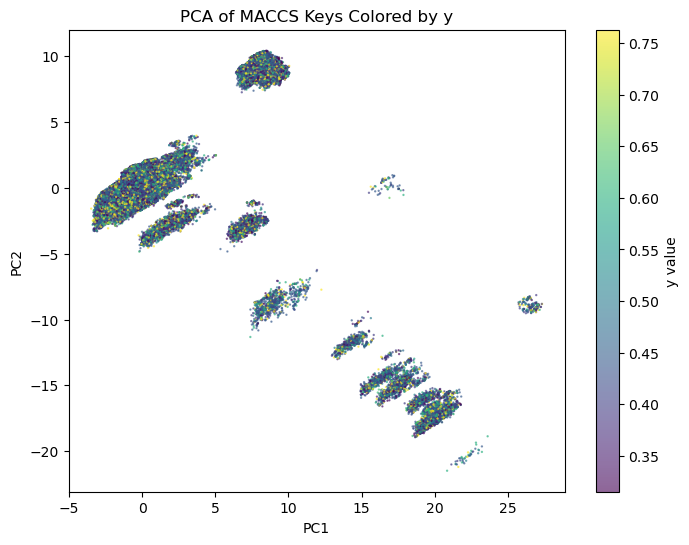

In [46]:
# Standardize the MACCS features
scaler = StandardScaler()
maccs_scaled = scaler.fit_transform(maccs_features_df.drop(columns=["y"]))
pca = PCA(n_components=2)  # You can also try n_components=3 for 3D
maccs_pca = pca.fit_transform(maccs_scaled)
Q3 = maccs_features_df["y"].quantile(0.90)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(maccs_pca[:, 0], maccs_pca[:, 1], 
                      c=maccs_features_df["y"], 
                      cmap="viridis", alpha=0.6, s= 0.5,
                     vmax=Q3,
                     )
plt.colorbar(scatter, label="y value")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MACCS Keys Colored by y")
plt.show()

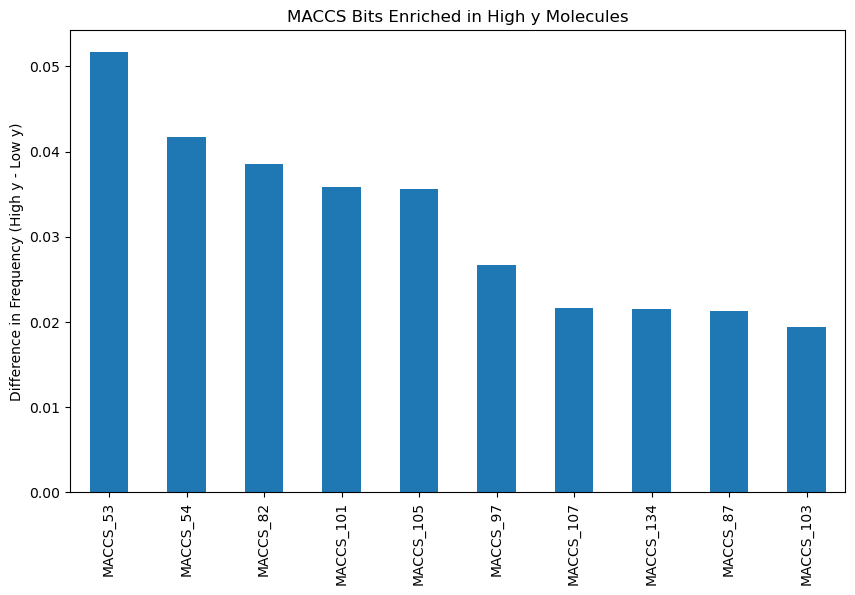

In [47]:
# Split molecules into high and low y
median_y = maccs_features_df["y"].median()
high_y = maccs_features_df[maccs_features_df["y"] > median_y]
low_y = maccs_features_df[maccs_features_df["y"] <= median_y]

# Calculate the frequency of each bit in high vs. low y
high_y_freq = high_y.drop(columns=["y"]).mean()
low_y_freq = low_y.drop(columns=["y"]).mean()

# Calculate the difference in frequency
freq_diff = high_y_freq - low_y_freq
freq_diff.sort_values(ascending=False, inplace=True)

# Plot the top 10 bits enriched in high y
plt.figure(figsize=(10, 6))
freq_diff.head(10).plot(kind="bar")
plt.title("MACCS Bits Enriched in High y Molecules")
plt.ylabel("Difference in Frequency (High y - Low y)")
plt.show()

***Physicohemical features***

In [37]:
from featurizer import PhysChemFeaturizer
X_train, y_train = PhysChemFeaturizer().featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [08:57<00:00, 1489.67it/s]

(800000, 5)


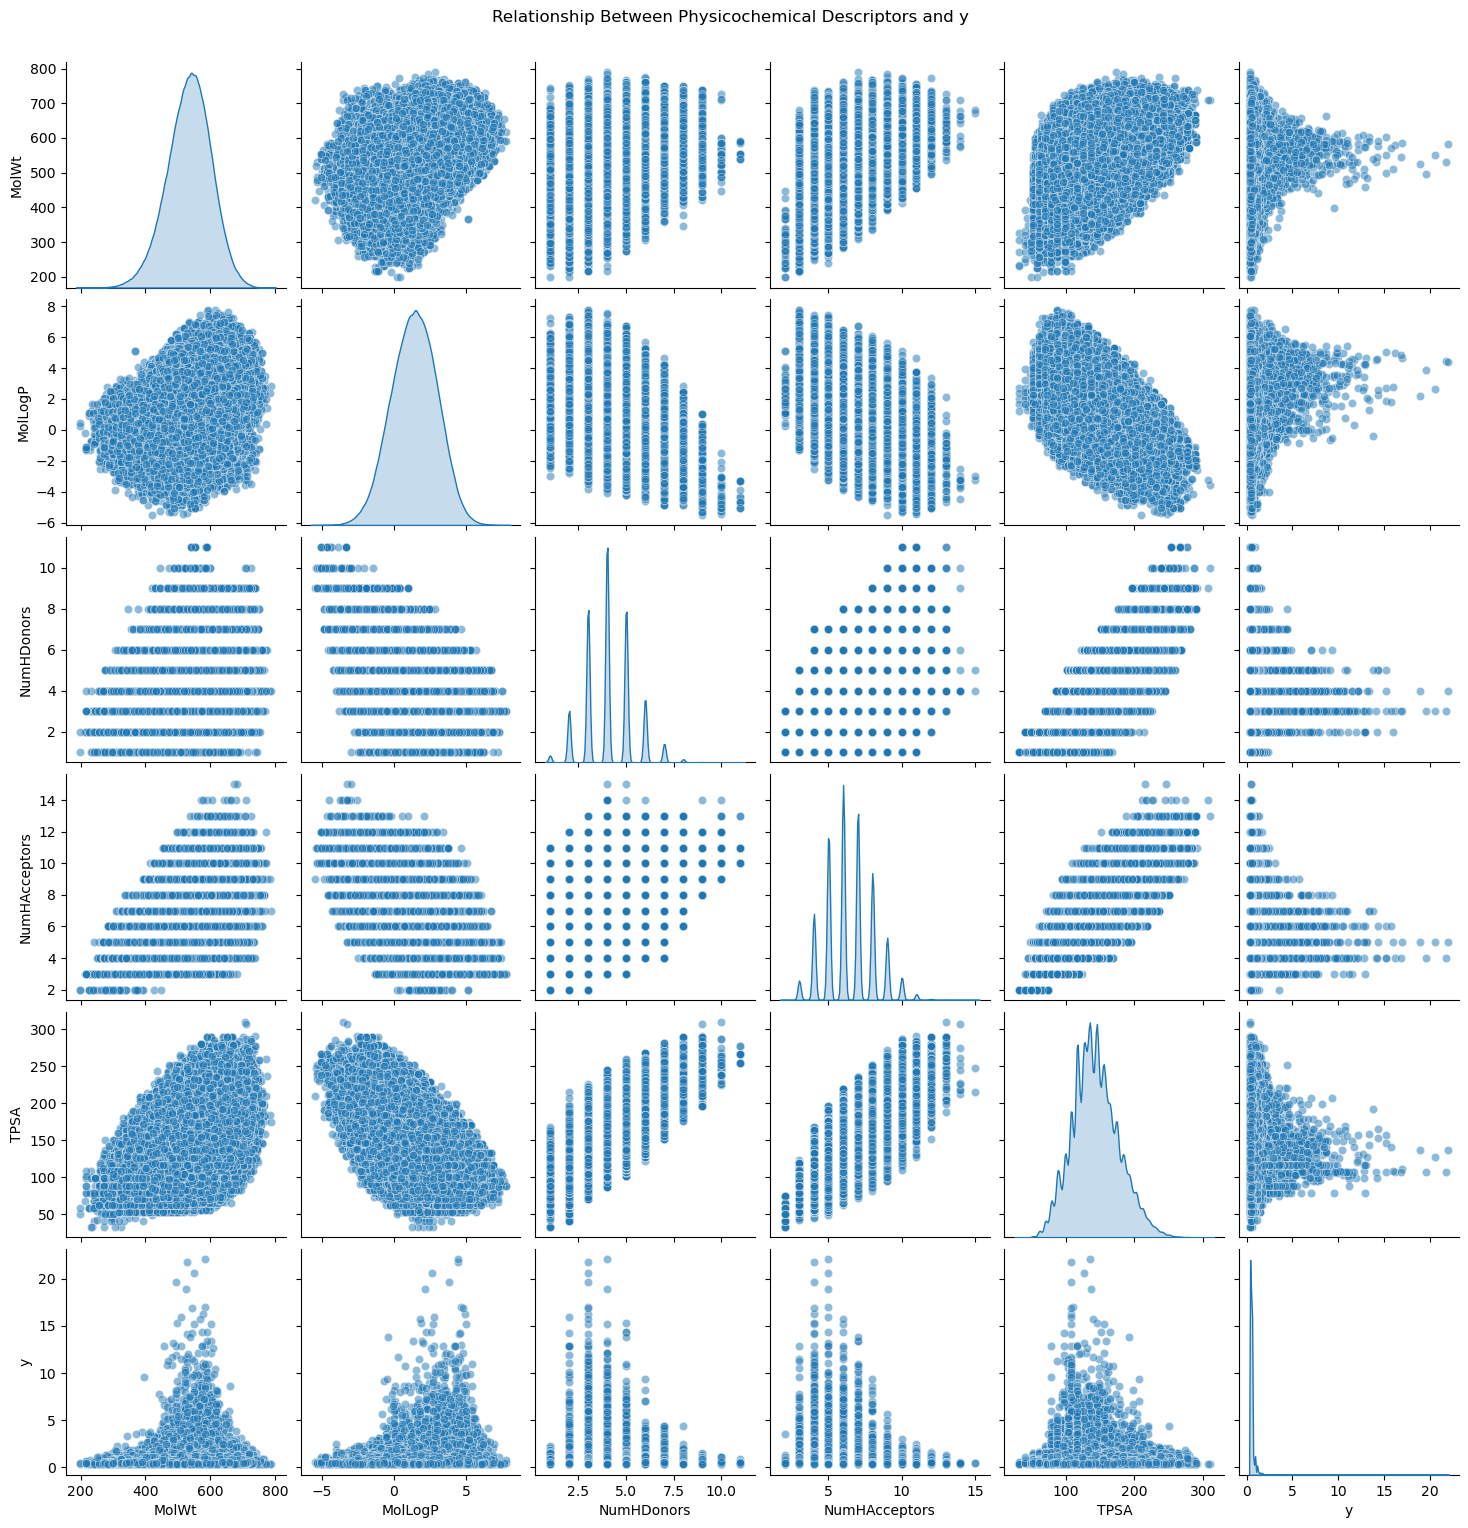

In [38]:
X_train_df = pd.DataFrame(X_train, columns=["MolWt","MolLogP","NumHDonors","NumHAcceptors","TPSA"])
X_train_df['y'] = y_train

sns.pairplot(X_train_df, diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Relationship Between Physicochemical Descriptors and y", y=1.02)
plt.show()

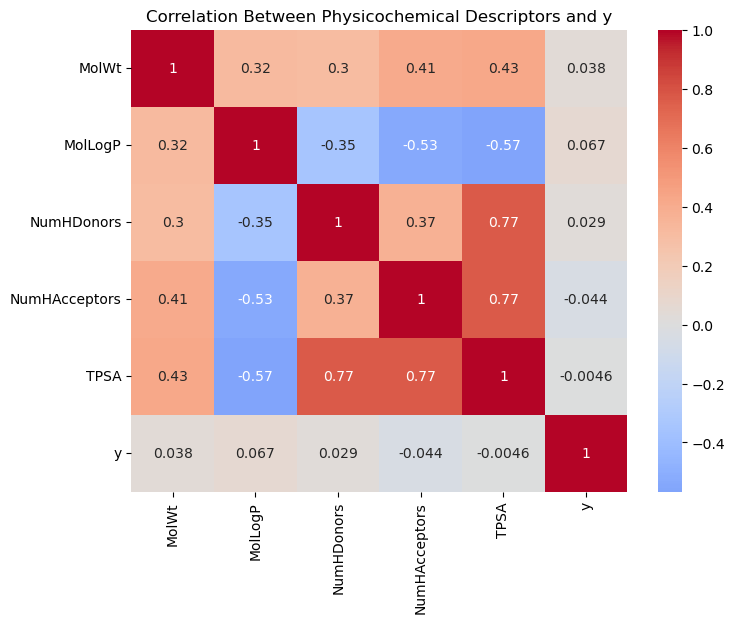

In [39]:
# Calculate correlations
corr_matrix = X_train_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Physicochemical Descriptors and y")
plt.show()

***Substructure Count***

In [40]:
from featurizer import SubstructureCountFeaturizer
substructure_featurizer = SubstructureCountFeaturizer()
X_train, y_train = substructure_featurizer.featurize_df(df_train, smiles_col="smiles", label_col="y")
print(X_train.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [04:55<00:00, 2702.80it/s]


(800000, 8)


In [41]:
# Column names for substructure counts
substructure_feature_names = list(substructure_featurizer.substructures.keys())

# Create a DataFrame
substructure_features_df = pd.DataFrame(
    X_train, columns=substructure_feature_names
)
substructure_features_df["y"] = y_train  # Add the 'y' values as a column
# Summary statistics for each substructure
print(substructure_features_df.describe())

       aromatic_rings       halogens       hydroxyl         amines  \
count   800000.000000  800000.000000  800000.000000  800000.000000   
mean        12.327284       0.638101       0.145455       3.482791   
std          5.378977       0.975234       0.398322       0.908567   
min          0.000000       0.000000       0.000000       1.000000   
25%          9.000000       0.000000       0.000000       3.000000   
50%         12.000000       0.000000       0.000000       4.000000   
75%         17.000000       1.000000       0.000000       4.000000   
max         33.000000       8.000000       5.000000       8.000000   

       carboxylic_acid        ketones         esters         amides  \
count    800000.000000  800000.000000  800000.000000  800000.000000   
mean          0.018873       2.667539       0.074588       3.903939   
std           0.136075       0.843891       0.262725       0.808630   
min           0.000000       0.000000       0.000000       1.000000   
25%           

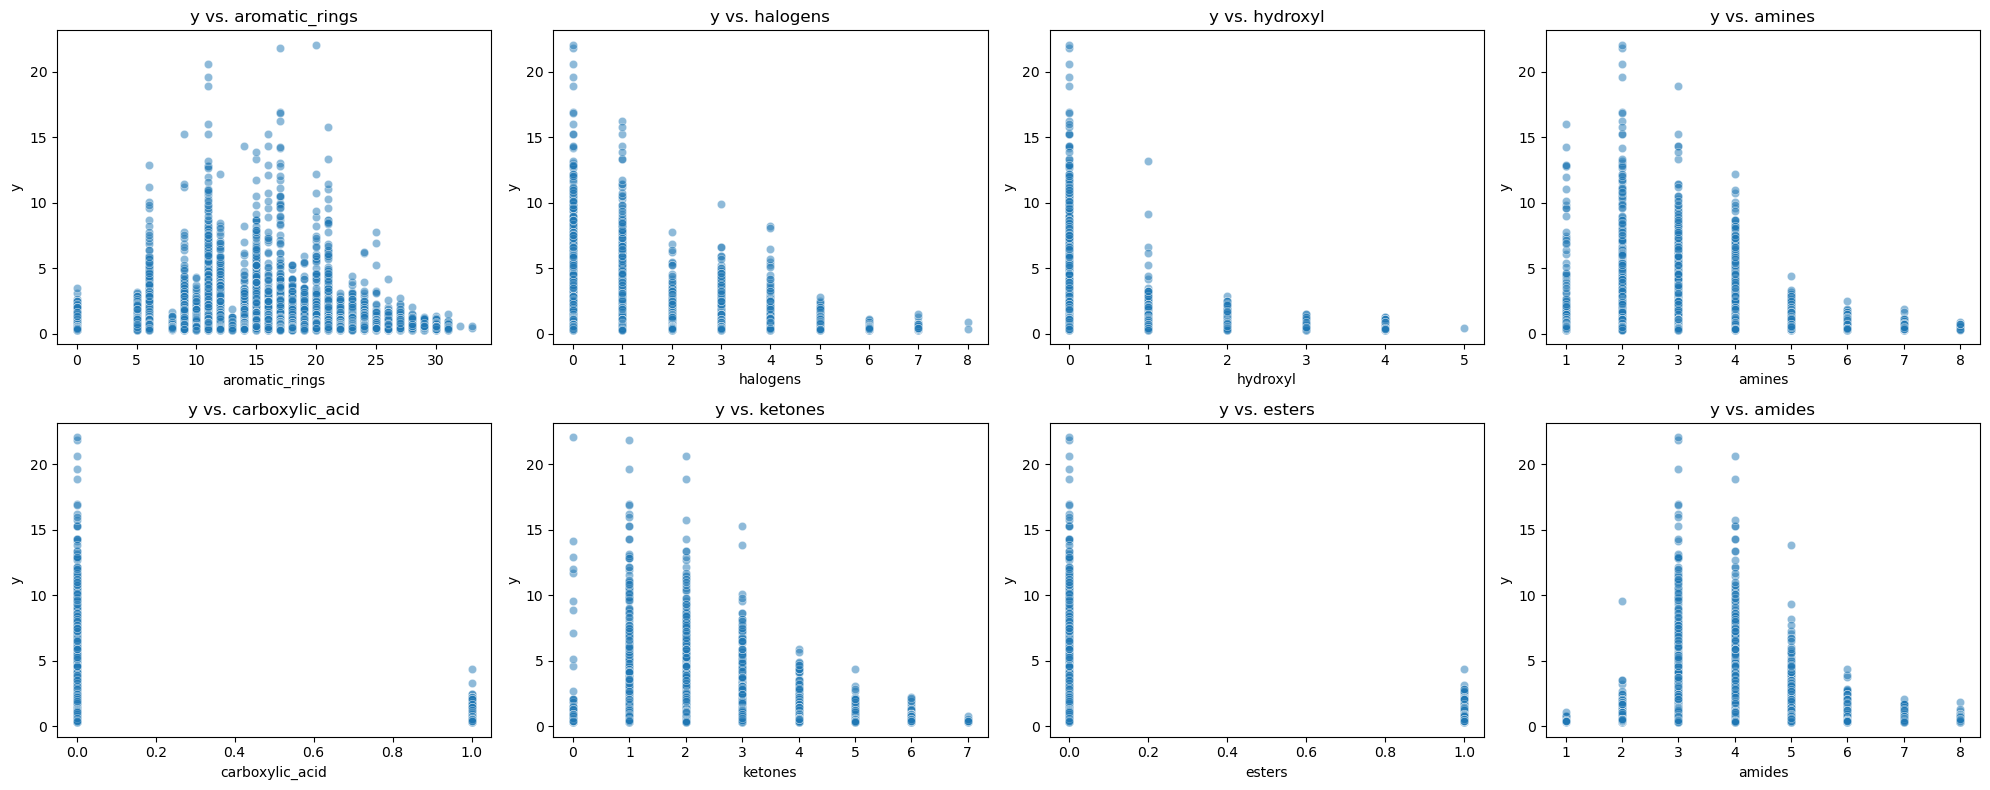

In [42]:
fig, axes = plt.subplots(2, 4, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten for easy indexing

# Plot each feature
for i, substructure in enumerate(substructure_feature_names):
    sns.scatterplot(
        data=substructure_features_df,
        x=substructure,
        y="y",
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f"y vs. {substructure}")

plt.tight_layout()
plt.show()

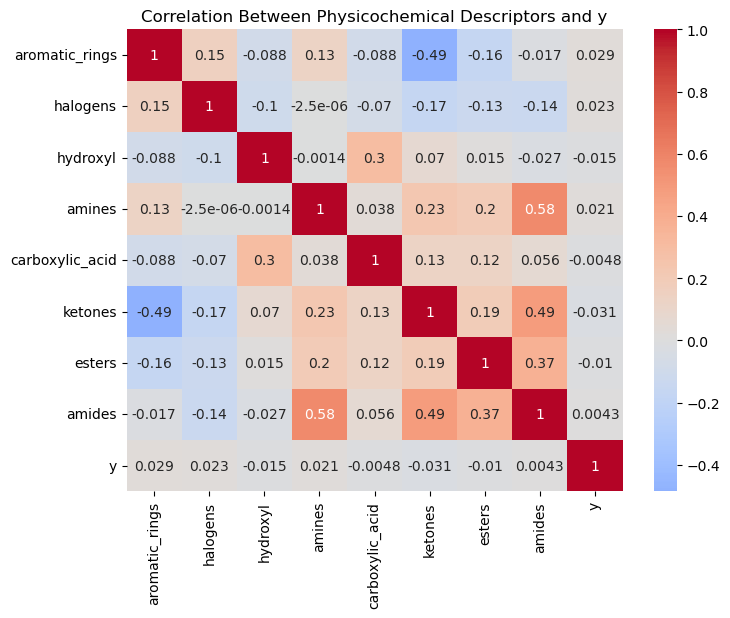

In [43]:
# Calculate correlations
corr_matrix = substructure_features_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Physicochemical Descriptors and y")
plt.show()

***ChemBERTa embeddings*** 

In [4]:
from featurizer import ChemBERTaFeaturizer
chemberta_featurizer = ChemBERTaFeaturizer()
chemberta_features, y = chemberta_featurizer.featurize_df(df_train, smiles_col="smiles", label_col="y")
print("ChemBERTa features shape:", chemberta_features.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800000/800000 [48:14<00:00, 276.42it/s]


ChemBERTa features shape: (800000, 384)


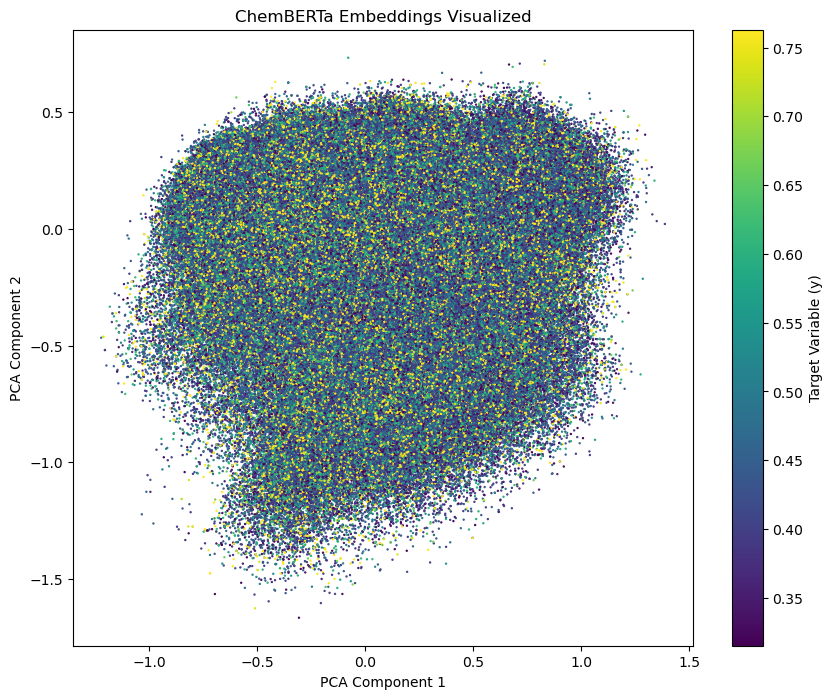

In [5]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(chemberta_features)
P90= np.percentile(df_train['y'], 90)
# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df_train['y'],
            cmap='viridis', vmax = P90, s=0.5)
plt.colorbar(label='Target Variable (y)')
plt.title('ChemBERTa Embeddings Visualized')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()